# Notebook for investigating network accuracy of surrogates

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import sys
from pathlib import Path

### Load all surrogate statistics
folder_path = Path('/Users/lmmi/anon_sbm/results/surrogate_statistics')

# find all log files in the logs directory
stat_files = list(folder_path.glob("*.csv"))

In [8]:
len(stat_files)

36

In [9]:
def determine_block_size(stat_file):
    """
    Determine min_block_size from the filename.

    min_block_size is encoded in filename as *min_block_size_{min_block_size}*.csv
    """

    # drop .csv extension
    if stat_file.name.endswith('.csv'):
        stat_file = stat_file.with_suffix('')

    # find location of substring 'min_block_size_'
    index = stat_file.name.find('min_block_size_')

    tail = stat_file.name[index + len('min_block_size_'):]
    size = tail.split('_')[0]

    # check if size is a digit
    if not size.isdigit():
        print(size)
        raise ValueError(f"Invalid size in filename: {stat_file.name}")
    return int(size)

In [10]:
df_list = []

for stat_file in stat_files:
    df = pd.read_csv(stat_file)
    df["block_size"] = determine_block_size(stat_file)
    df['surrogate'] = [int(surrogate_str.split("_")[1]) for surrogate_str in df['surrogate']]

    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

In [11]:
marker_styles = {
    "congress_twitter": "o",
    "caltech_fb": "s",
    "eu_email": "D",
    "lastfm_asia": "x",
    "wiki_vote": "+",
    "enron_email": "+",
}

# load nice colormaps
from matplotlib import colormaps as cm

cmap = cm.get_cmap("tab10")

colors = {
    "congress_twitter": "teal",
    "caltech_fb": "salmon",
    "eu_email": "black",
    "lastfm_asia": cmap(0),
    "wiki_vote": cmap(0.5),
    "enron_email": cmap(1),
}

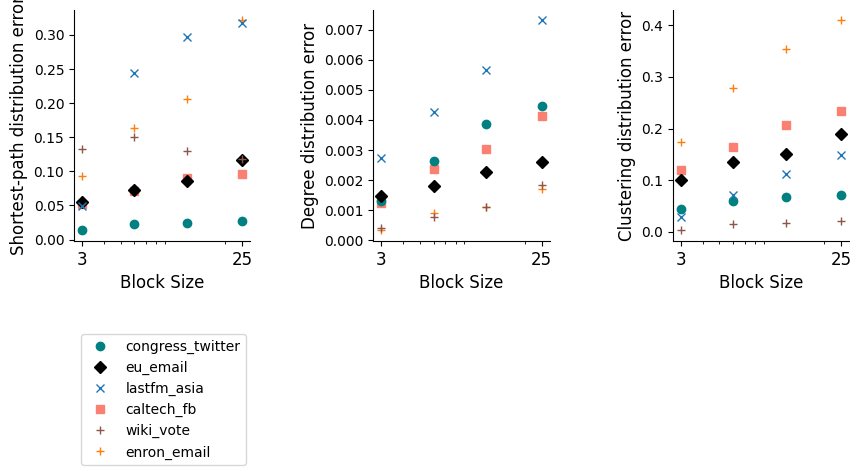

In [12]:
### Visualize reconstruction error across block sizes and datasets
fig, ax = plt.subplots(
    figsize=(10, 3),
    ncols = 3,
    sharex=True,
    sharey=False,
    # set spacing between subplots
    gridspec_kw={'wspace': 0.7}
    )

for group in df.groupby(['block_size', 'dataset']):
    block_size, dataset = group[0]
    group_data = group[1]

    marker = marker_styles[dataset]
    color = colors[dataset]

    # plot the shortest-path reconstruction error for each surrogate
    path_errors = group_data['shortest_path'].mean()
    ax[0].plot(
        [block_size],
        [path_errors],
        label=f"{dataset}",
        marker=marker,
        linewidth=0,
        color=color
    )

    # plot the degree-dist reconstruction error for each surrogate
    degree_errors = group_data['degree'].mean()
    ax[1].plot(
        [block_size],
        [degree_errors],
        marker=marker,
        linewidth=0,
        color=color
    )

    clustering_errors = group_data['clustering'].mean()
    ax[2].plot(
        [block_size],
        [clustering_errors],
        marker=marker,
        linewidth=0,
        color=color
    )
        
ax[0].set_ylabel('Shortest-path distribution error', fontsize=12)
ax[1].set_ylabel('Degree distribution error', fontsize=12)
ax[2].set_ylabel('Clustering distribution error', fontsize=12)

xticks = df['block_size'].unique()[::3]
for axis in ax:
    axis.set_xscale('log')
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticks, fontsize=12)
    axis.spines[['top', 'right']].set_visible(False)
    axis.set_xlabel('Block size', fontsize=12)

    axis.set_xlabel('Block Size')


### Construct legend from single axis
handles, labels = ax[0].get_legend_handles_labels()
legend_set = set(zip(labels, handles))

by_label = dict(legend_set)
ax[0].legend(
    by_label.values(),
    by_label.keys(),
    loc='lower left',
    bbox_to_anchor=(0, -1),
    fontsize=10,
    )

plt.show(fig)

In [13]:
import numpy as np

rng = np.random.default_rng(42)

In [14]:
import scipy.sparse as sp

a = sp.random(100, 100, density=0.1, format='csr', random_state=rng)

In [15]:
a.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48176355, 0.75232891, 0.        , ..., 0.        , 0.        ,
        0.86413683],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.42176606, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
# flatten the 
a[0, :]

<1x100 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [1]:
from sbm.noisy_fit import HeterogeneousGaussNoise, NaiveDegreeGaussNoise, create_sbm_noise
from sbm.io import SBMWriter
from pathlib import Path
import numpy as np

In [2]:
sbm = SBMWriter.load(
    Path("/Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_caltech_fb_cooling_rate_0_999_force_undirected_True_init_method_ProneKMeans_min_block_size_12_n_iter_100000_temperature_1_0")
)

Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_caltech_fb_cooling_rate_0_999_force_undirected_True_init_method_ProneKMeans_min_block_size_12_n_iter_100000_temperature_1_0


In [4]:
rng = np.random.default_rng(0)
noiser = create_sbm_noise(
    sbm, eps=1.0, delta=1e-6, alpha=0.999,
    noise_type="heterogeneous_gaussian"
    )

assert isinstance(noiser, NaiveDegreeGaussNoise)
print(noiser.sigma_n_scalar, noiser.sigma_e_scalar)
noisy_fit = noiser.sample_sbm_fit(rng)


ValueError: index pointer size (2081) should be (65)